In [1]:
from collections import OrderedDict
from datetime import timedelta
import pandas as pd
import numpy as np
import pmdarima as pm
import matplotlib.pyplot as plt

In [2]:
# LOAD NAMES
dmkt = "C:/Users/Keegan/OneDrive/1 Studies/2021 - 2022/5003W/3 - Dissertation/5-Data/cleaned/univariate/market_indices/market_names.csv"
mkt_names = pd.read_csv(dmkt).values.tolist()
mkt_names = [item for sublist in mkt_names for item in sublist]

# LOAD DATA
dd = "C:/Users/Keegan/OneDrive/1 Studies/2021 - 2022/5003W/3 - Dissertation/5-Data/cleaned/univariate/market_indices/"
dirs = []
data = OrderedDict()
for i in range(len(mkt_names)):
    # concat strings to get directories
    nm = mkt_names[i]
    directory = dd+nm+".csv"
    # store
    dirs.append(directory)
    data[nm] = pd.read_csv(directory)
    del directory, nm

In [3]:
# Date parameters
E1 = pd.to_datetime("2020-01-13")
E2 = pd.to_datetime("2020-01-24")
E3 = pd.to_datetime("2020-02-24")
E4 = pd.to_datetime("2020-03-09")

CUT1 = pd.to_datetime("2019-04-29")
CUT2 = pd.to_datetime("2020-06-01")

In [4]:
var_mode = 'log_prices'

In [5]:
# select data
MKT = "SPX.Index"
dataset = data[MKT].copy(deep=True)
# format dates
dataset['date'] = pd.to_datetime(dataset['date'].values)
# change colname for ease of use
dataset = dataset.rename(columns={'date':'date', MKT:'val'})

if var_mode == 'log_returns':
    # extract price level, calc log_returns, store as dataset
    log_returns = np.log(dataset.val.shift(-1) / dataset.val)
    log_returns = log_returns[~np.isnan(log_returns)]

    dataset.val = log_returns
    del log_returns

elif var_mode == 'log_prices':
    # extract price level, calc log_prices, store as dataset
    log_prices = np.log(np.copy(dataset.val.values))
    log_prices = log_prices[~np.isnan(log_prices)]

    dataset.val = log_prices
    del log_prices
else:
    Exception("Variable calculation not specified. Please specify var_mode with one of the following: ['log_returns', 'log_prices']")

# set data splitting parameters
date1 = E1
date2 = CUT2+timedelta(days=365)

# split dataset
Y = dataset.val
X = pd.concat([pd.to_datetime(dataset.date), pd.Series(range(len(Y)))], axis=1).rename({'date':'date',0:'index'},axis=1)
# X_in = X.index[X.date < date1]
# X_out = X.index[X.date >= date1]
train = dataset[(dataset["date"] < date1)] # & (dataset['date'] > pd.to_datetime("2016-01-01")) 
test = dataset[(dataset["date"] >= date1)]
# Inspect
print(
    'TABULAR DATA:', '\n',
    'train.shape: ', train.shape, '\n',
    'test.shape: ', test.shape
    )

# retain date seqs
dtrain, dtest = pd.to_datetime(train.date), pd.to_datetime(test.date)
# format structures (and dtypes) for arima
Y, train, test = Y.values, train.val.values, test.val.values
# Inspect and compare
print(
    'DATA VECTORS:', '\n',
    'train.shape: ', train.shape, '\n',
    'test.shape: ', test.shape
    )

TABULAR DATA: 
 train.shape:  (3026, 2) 
 test.shape:  (532, 2)
DATA VECTORS: 
 train.shape:  (3026,) 
 test.shape:  (532,)


ARIMA constructor

In [6]:
ORDER = (1,1,1)
# construct arima model of order ORDER
arima = pm.ARIMA(order=ORDER, out_of_sample_size=int(test.shape[0]))
fit = arima.fit(Y)
train_fit = fit.fittedvalues()

ARIMA predictions

In [7]:
ORDER = (1,1,1)
# construct arima model of order ORDER
arima = pm.ARIMA(order=ORDER, out_of_sample_size=int(test.shape[0]))
fit = arima.fit(Y)
# train_fit = fit.fittedvalues()
pred_in = fit.predict_in_sample(start=1, end=Y.shape[0], dynamic=False)

In [ ]:
# def forecast_one_step():
#     fc, conf_int = fit.predict(n_periods=1, return_conf_int=True)
#     return (
#         fc.tolist()[0],
#         np.asarray(conf_int).tolist()[0])

# forecasts = []
# confidence_intervals = []

# for new_ob in test:
#     fc, conf = forecast_one_step()
#     forecasts.append(fc)
#     confidence_intervals.append(conf)

#     # Updates the existing model with a small number of MLE steps
#     fit.update(new_ob)

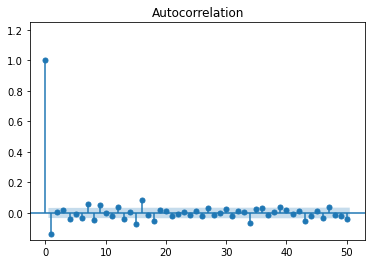

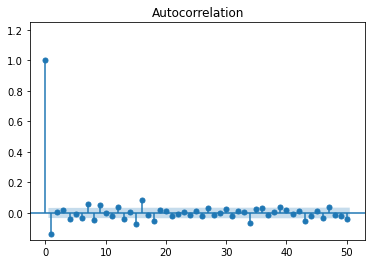

In [42]:
from statsmodels.graphics.tsaplots import acf, plot_acf
diff = np.diff(Y,n=1)
acorr = acf(diff,nlags=50)
plot_acf(diff, lags=50, auto_ylims=True)

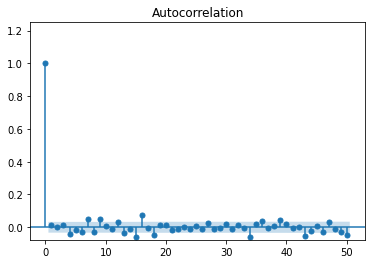

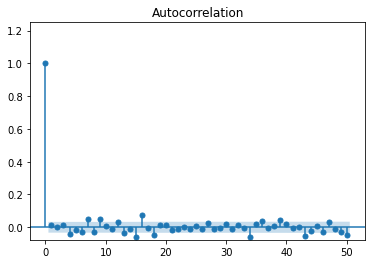

In [45]:
from statsmodels.graphics.tsaplots import acf, plot_acf
diff = np.diff(pred_in,n=1)
acorr = acf(diff,nlags=50)
plot_acf(diff, lags=50, auto_ylims=True)

In [348]:
fit.resid()

array([ 7.25218573e+00,  2.90343043e-03, -1.84292248e-02, ...,
        2.69126515e-03, -2.15016652e-02, -1.05722143e-02])

In [313]:
fit.resid()

array([ 7.25218350e+00,  2.90120064e-03, -1.84859453e-02, ...,
        1.84987553e-03, -2.11417124e-02, -1.00789259e-02])

In [273]:
# split the list into components
upper = []
lower = []
for up, lw in confidence_intervals:
    upper.append(up)
    lower.append(lw)

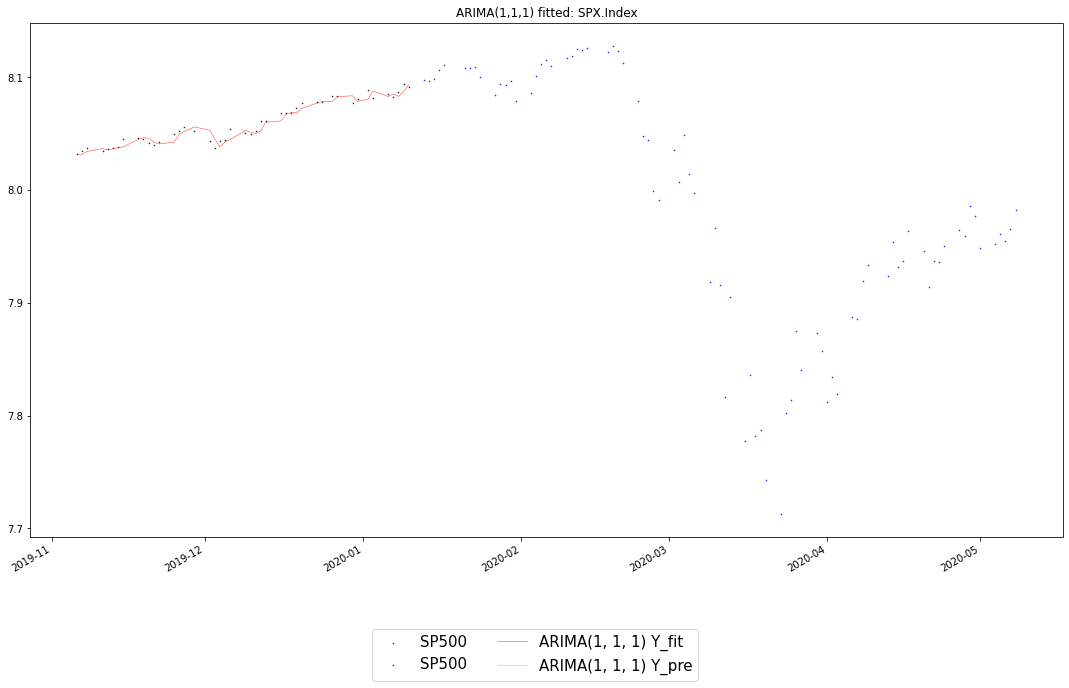

In [332]:
MIN_VAL = 1 + 2980
MAX_VAL_TEST = test.shape[0] -450
SCATTER = 1
TRANSLUCENT = 0.8
LINEWIDTH = 0.5
# Plot actual test vs. forecasts:
fig, ax = plt.subplots()
ax.scatter(
    dtrain[MIN_VAL:dtrain.shape[0]],
    train[MIN_VAL:dtrain.shape[0]],
    marker = '.',
    s = SCATTER,
    alpha = 1,
    color = 'black',
    label = "SP500"
    )
ax.scatter(
    dtest[0:MAX_VAL_TEST],
    test[0:MAX_VAL_TEST],
    marker = '.',
    s = SCATTER,
    alpha = 1,
    color = 'blue',
    label = "SP500"
    )
ax.plot(
    dtrain[MIN_VAL:dtrain.shape[0]],
    fit.fittedvalues()[MIN_VAL:dtrain.shape[0]],
    color = 'red',
    alpha = TRANSLUCENT,
    linewidth = LINEWIDTH,
    label = ('ARIMA'+str(ORDER)+' Y_fit')
    )
ax.plot(
    dtest[0:MAX_VAL_TEST],
    forecasts[0:MAX_VAL_TEST],
    color = 'orange',
    alpha = TRANSLUCENT,
    linewidth = LINEWIDTH,
    label = ('ARIMA'+str(ORDER)+' Y_pre')
    )
plt.figure(num=1, figsize=(8,6))
fig.legend(loc=8, ncol=2, prop={'size':15})
fig.autofmt_xdate()
fig.set_size_inches(18.5, 10.5)
plt.title('ARIMA(1,1,1) fitted: '+str(MKT))
plt.show()
fig.savefig("ARIMA(1,1,1), full-fit, CLOSE_UP.png", dpi=400, facecolor='white', edgecolor='white',bbox_inches = 'tight', pad_inches = 0.1)

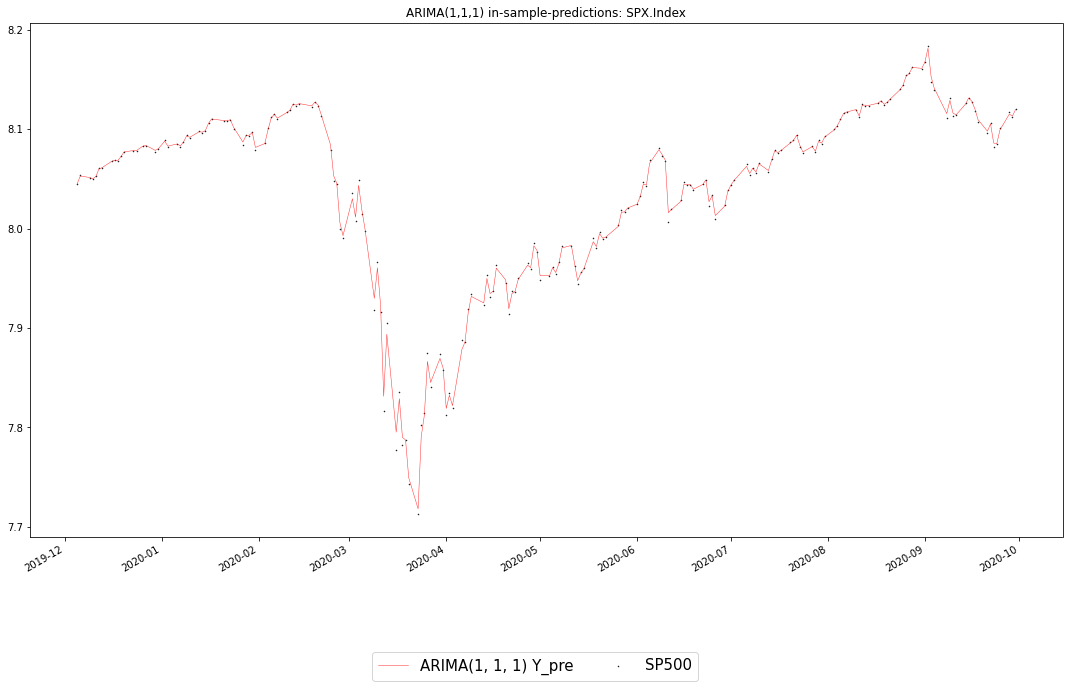

In [346]:
MIN_VAL = 1 + 3000
MAX_VAL = Y.shape[0] - 350
SCATTER = 1
TRANSLUCENT = 0.8
LINEWIDTH = 0.5

fig, ax = plt.subplots()
ax.plot(
    X.date.values[MIN_VAL:MAX_VAL],
    pred_in[MIN_VAL:MAX_VAL],
    color = 'red',
    alpha = TRANSLUCENT,
    linewidth = LINEWIDTH,
    label = ('ARIMA'+str(ORDER)+' Y_pre')
    )
ax.scatter(
    X.date.values[MIN_VAL:MAX_VAL],
    Y[MIN_VAL:MAX_VAL],
    marker = '.',
    s = SCATTER,
    alpha = 1,
    color = 'black',
    label = "SP500"
    )
plt.figure(num=1, figsize=(8,6))
fig.legend(loc=8, ncol=2, prop={'size':15})
fig.autofmt_xdate()
fig.set_size_inches(18.5, 10.5)
plt.title('ARIMA(1,1,1) in-sample-predictions: '+str(MKT))
plt.show()
fig.savefig("ARIMA(1,1,1), IN_SAMPLE_PRED, CLOSE_UP.png", dpi=400, facecolor='white', edgecolor='white',bbox_inches = 'tight', pad_inches = 0.1)

In [ ]:
MIN_VAL = 1 + 2980
MAX_VAL_TEST = test.shape[0] -450
SCATTER = 1
TRANSLUCENT = 0.8
LINEWIDTH = 0.5
# Plot actual test vs. forecasts:
fig, ax = plt.subplots()
ax.scatter(
    dtrain[MIN_VAL:dtrain.shape[0]],
    train[MIN_VAL:dtrain.shape[0]],
    marker = '.',
    s = SCATTER,
    alpha = 1,
    color = 'black',
    label = "SP500"
    )
ax.scatter(
    dtest[0:MAX_VAL_TEST],
    test[0:MAX_VAL_TEST],
    marker = '.',
    s = SCATTER,
    alpha = 1,
    color = 'blue',
    label = "SP500"
    )
ax.plot(
    dtrain[MIN_VAL:dtrain.shape[0]],
    pred[MIN_VAL:dtrain.shape[0]],
    color = 'red',
    alpha = TRANSLUCENT,
    linewidth = LINEWIDTH,
    label = ('ARIMA'+str(ORDER)+' Y_fit')
    )
# ax.plot(
#     dtest[0:MAX_VAL_TEST],
#     forecasts[0:MAX_VAL_TEST],
#     color = 'orange',
#     alpha = TRANSLUCENT,
#     linewidth = LINEWIDTH,
#     label = ('ARIMA'+str(ORDER)+' Y_pre')
#     )
plt.figure(num=1, figsize=(8,6))
fig.legend(loc=8, ncol=2, prop={'size':15})
fig.autofmt_xdate()
fig.set_size_inches(18.5, 10.5)
plt.title('ARIMA(1,1,1) fitted: '+str(MKT))
plt.show()
# fig.savefig("ARIMA(1,1,1), full-fit, CLOSE_UP.png", dpi=400, facecolor='white', edgecolor='white',bbox_inches = 'tight', pad_inches = 0.1)

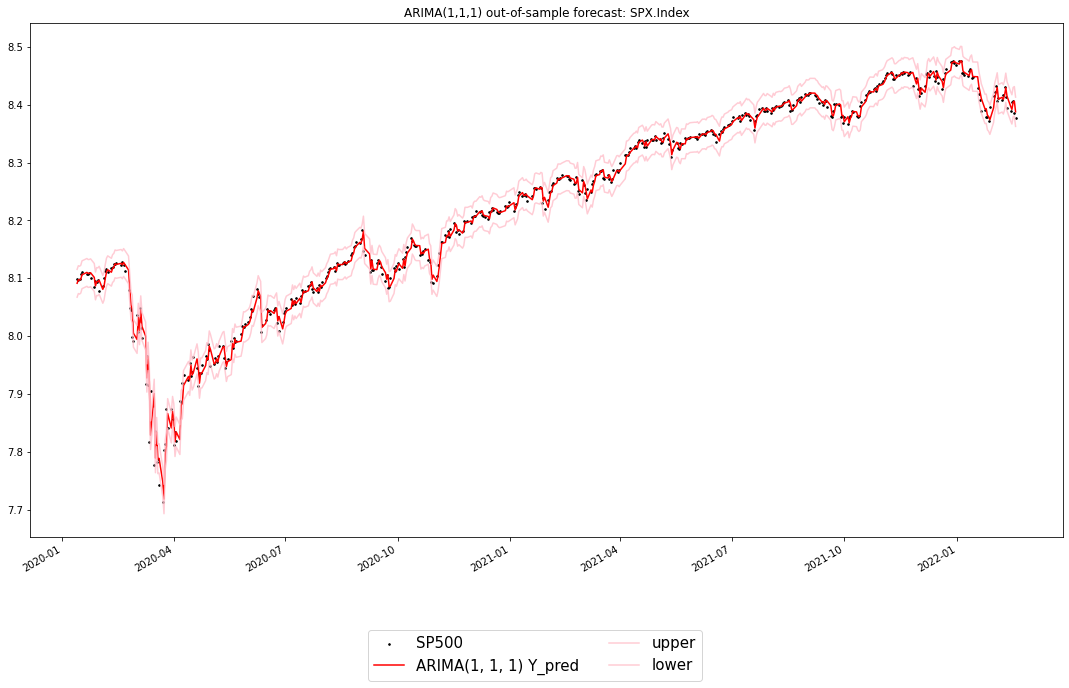

In [296]:
# plot of insample fit and updated model
fig, ax = plt.subplots()
ax.scatter(
    dtest,
    test,
    marker = '.',
    s = 10,
    alpha = 1,
    color = 'black',
    label = "SP500"
    )
ax.plot(
    dtest,
    forecasts,
    color = 'red',
    alpha = 1,
    label = ('ARIMA'+str(ORDER)+' Y_pred')
    )
ax.plot(
    dtest,
    upper,
    color = 'pink',
    alpha = TRANSLUCENT,
    label = ('upper')
    )
ax.plot(
    dtest,
    lower,
    color = 'pink',
    alpha = TRANSLUCENT,
    label = ('lower')
    )
plt.figure(num=1, figsize=(8,6))
fig.legend(loc=8, ncol=2, prop={'size':15})
fig.autofmt_xdate()
fig.set_size_inches(18.5, 10.5)
plt.title('ARIMA(1,1,1) out-of-sample forecast: '+MKT)
plt.show()
fig.savefig('ARIMA(1,1,1) out-of-sample forecast'+MKT+'.png', dpi=400, facecolor='white', edgecolor='white',bbox_inches = 'tight', pad_inches = 0.1)

In [140]:
# proceedure predicts from arima model, one obs forward
LENGTH = test.shape[0]
n = 0

arima_predictions = np.empty(0)
upper = np.empty(0)
lower = np.empty(0)
for i in range(LENGTH):
    preds = fit.predict(X=test[n], n_periods=1, return_conf_int=True, dynamic=False)
    arima_predictions = np.concatenate(
        (arima_predictions,
        (preds[0]))
    )
    lower = np.append(lower,preds[1][0,0])
    upper = np.append(upper,preds[1][0,1])
    n=n+1
res = [arima_predictions,lower,upper]

# test for expected shapes
dims = [item.shape for item in res]
if (dims[0] != dims[1]) | (dims[1] != dims[2]):
    raise Exception("Dimensions of predicted vs confidence intervals do not match.")
else:
    del dims

In [ ]:
# # proceedure contructs ints to slice up the test data in a rolling window of a set size
# LENGTH = test.shape[0]

# m_periods = int(round(LENGTH/10, ndigits=0))
# rem = LENGTH % 10

# k = 0
# j = 10
# for i in range(m_periods):
#     if j >=m_periods:
#         # creates window that is bounded to the length of the dataset
#         # this prediction window gets smaller and smaller
#         j = m_periods
#         n_periods = range(j-10+k,j)
#         k=k+1
#         print(n_periods)
#     else:
#         # creates the window with len(window) = 10
#         n_periods = range(j-10,j)
#         print(n_periods) 
#         j = j+1

AUTOARIMA

In [ ]:
M=1
# Fit a simple auto_arima model
a_arima = pm.auto_arima(train, error_action='ignore', trace=True,
                        suppress_warnings=True, maxiter=5,
                        out_of_sample_size=347,
                        m=M, start_q=1, max_q=1)

In [ ]:
# Plot actual train data:
# fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig, ax = plt.subplots()
ax.plot(dtrain, train, color='blue', linewidth=0.3, label="SP500")
fig.legend()
fig.autofmt_xdate()
plt.title('Train data')
fig.savefig("train_returns.png", dpi=300, facecolor='white', edgecolor='white')

In [ ]:
# Plot actual test vs. forecasts:
fig, ax = plt.subplots()
ax.scatter(
    dtest,
    test,
    marker='.',
    s = 3,
    color = 'black',
    label="SP500"
    )
ax.plot(
    dtest,
    a_arima.predict(n_periods=test.shape[0]),
    color = 'red',
    alpha = 0.6,
    label=('arima'+str(a_arima.order))
    )

fig.legend()
fig.autofmt_xdate()
plt.title('Actual test samples vs. forecasts')
plt.show()
fig.savefig("brokenARIMA_returns_m="+str(M)+".png", dpi=300, facecolor='white', edgecolor='white')

In [ ]:
fig, ax = plt.subplots()
ax.plot(
    dtest,
    a_arima.predict(n_periods=test.shape[0]),
    color = 'red',
    alpha = 0.6,
    label=('ARIMA'+str(a_arima.order))
    )
fig.legend()
fig.autofmt_xdate()
plt.title('ARIMA'+str(a_arima.order)+' model')
plt.show()
fig.savefig(("brokenARIMA_returns_model_m="+str(M)+".png"), dpi=300, facecolor='white', edgecolor='white')

In [ ]:
# Plot actual test vs. forecasts:s
x = np.arange(test.shape[0])
fig = plt.figure()
ax1 = fig.add_subplot()
scatter = ax1.scatter(
    x,
    test,
    marker='.',
    s = 3,
    color = 'black'
    )
ax2 = fig.add_subplot()
line = ax2.plot(
    x,
    a_arima.predict(n_periods=test.shape[0]),
    color = 'red',
    alpha = 0.6,
    label=('arima'+str(a_arima.order))
    )
# plt.plot(x, test)
plt.title('Actual test samples vs. forecasts')
plt.show()
ax1.legend()